In [1]:
%matplotlib inline
import numpy as np
import requests
from scipy import ndimage
import math
import cv2
import random
import sys
import math
import matplotlib.pyplot as plt
np.set_printoptions(threshold=sys.maxsize)

In [2]:
def im2double(im):
    info = np.iinfo(im.dtype) # Get the data type of the input image
    return im.astype(np.float) / info.max # Divide all values by the largest possible value in the datatype

In [3]:
url = "http://6.869.csail.mit.edu/fa19/psets19_/pset4/rings.jpg"
resp = requests.get(url)
with open ("rings.jpg", "wb") as f:
    f.write(resp.content)
url = "http://6.869.csail.mit.edu/fa19/psets19_/pset4/texture.jpg"
resp = requests.get(url)
with open ("texture.jpg", "wb") as f:
    f.write(resp.content)


## "Find_matches" function

In [4]:
def Find_matches(template, sample, G):
    
    # Size constants
    n, _, nCh = sample.shape 
    w, _, _ = template.shape
    dw = int(w/2)
    size = n - w + 1
    
    # Param for candidate pixels
    epsilon = 0.1
    
    # Preallocate
    SSD = np.zeros((size*size))
    
    # Filter kernel for NaN values
    msk =(~np.isnan(template[: , : , 0]))
    G = np.multiply(G, msk.astype(np.float64))
    G = G.reshape(w*w, 1) / np.sum(G)
    
    # Filter template
    template = np.nan_to_num(template).reshape(w*w, 1, nCh)
    
    # Stride params
    stride_shape = w, w, size, size, nCh
    s0, s1, s2 = sample.strides
    strides = s0, s1, s0, s1, s2
    
    # Set up efficient view of source image
    out_view = np.lib.stride_tricks.as_strided(sample, shape=stride_shape, strides=strides)
    columns = out_view.reshape(w*w, size*size, nCh)
    
    # Get distances for all patches and channels, sum channels for each patch and apply mask,
    # then sum for every pixel in each patch
    dists = (template - columns)**2
    weighted_diffs = np.sum(dists, axis=2)*G
    SSD = np.sum(weighted_diffs, axis=0)
    
    # Return candidates
    min_ssd = np.min(SSD)
    
    SSD = SSD.reshape(size, size)
    idx = np.where(SSD <= min_ssd*(1 + epsilon))
            
    return sample[idx[0] + dw, idx[1] + dw], SSD[idx]

    
    


## "Synth_texture" function

In [5]:
def Synth_texture(sample, w, s):

    ## Normalizing pixel intensity
    sample = im2double(sample)
    seed_size = 3
    
    [sheight, swidth, nChannels] = sample.shape
    
    theight = s[0]
    twidth = s[1]
    winwidth = int(w/2)
    
    synthIm = np.full((theight, twidth, nChannels), np.nan)

    # Guassian kernel
    G = np.zeros((w, w))
    G[int(w/2), int(w/2)] = 1
    G = ndimage.gaussian_filter(G, w/6.4, mode="wrap")
    G = G/np.sum(G)
    
    ### Initialization: pick a random 3x3 patch from sample and place in the middle of the synthesized image.
    ### Just for convenience, keep some space (SEED_SIZE) from the boundary
    ##  i0=32; j0=4
    i0 = round(seed_size + np.random.uniform(0,1) * (sheight - 2 * seed_size))
    j0 = round(seed_size + np.random.uniform(0,1) * (swidth - 2 * seed_size))
    c = [round(.5 * x) for x in s]
    synthIm[c[0]: c[0] + seed_size , c[1]: c[1] + seed_size ,:] = sample[i0: i0 + seed_size , j0: j0 + seed_size,:]
     
    ### bitmap indicating filled pixels
    filled = np.zeros(s)
    filled[c[0]: c[0] + seed_size , c[1]: c[1] + seed_size ] = 1
    n_filled = int(np.sum(filled))
    n_pixels = s[0]*s[1]

    ### Main Loop
    next_p = n_pixels / 10
    delta_start_value = 0.3
    delta = delta_start_value
    
    while(n_filled < n_pixels):
        
        #report progress
        if(n_filled > next_p):
            print( round(100 * n_filled / n_pixels), '% complete', )
            next_p += n_pixels / 10
        
        # Find next set of unfilled pixels
        boundary = ndimage.binary_dilation(filled).astype(filled.dtype) - filled
        (ii, jj) = np.ix_(*np.nonzero(boundary))
        
        for i in range(len(ii)):
            
            y, x = int(ii[i,0]), int(jj[0,i])
            
            # Main window indexes
            x_max = x + winwidth + 1
            x_min = x - winwidth
            y_max = y + winwidth + 1
            y_min = y - winwidth
            
            # Sample indexes to handle the edges
            sx_max = min(x_max, s[1])
            sx_min = max(x_min,    0)
            sy_max = min(y_max, s[0])
            sy_min = max(y_min,    0)
            
            # Template indexes to handle the edges
            tx_max = w - (x_max - sx_max)
            tx_min = 0 - (x_min - sx_min)
            ty_max = w - (y_max - sy_max)
            ty_min = 0 - (y_min - sy_min)
            
            # Extract template window
            template = np.full((w, w, nChannels), np.nan)
            template[ty_min : ty_max, tx_min : tx_max, : ] = synthIm[sy_min : sy_max, sx_min : sx_max, :]
            
            # Find matches
            pixels, errors = Find_matches(template, sample, G)
            assert pixels.shape[0] != 0
            
            # Parse result
            rand_pix_idx = np.random.choice(np.arange(pixels.shape[0]))
            
            if errors[rand_pix_idx] <= delta:
                delta = delta_start_value
                filled[y,x] = 1
                synthIm[y,x,:] = pixels[rand_pix_idx, :]

        # Check if we are making progress, ie we filled a value this iteration
        if not (int(np.sum(filled)) - n_filled > 0):
            delta = delta * 1.1
            print("Not making progress, increasing delta to", delta)

            
        n_filled = int(np.sum(filled))
        
    return synthIm

## main function

## Image rings.jpg | w = 5 ##
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


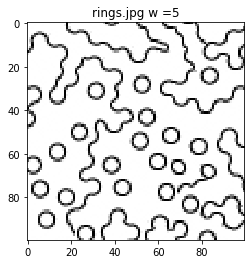

## Image rings.jpg | w = 7 ##
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete
Not making progress, increasing delta to 0.33


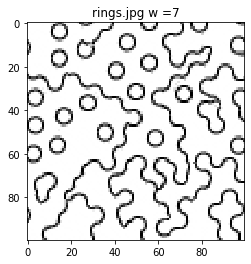

## Image rings.jpg | w = 13 ##
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


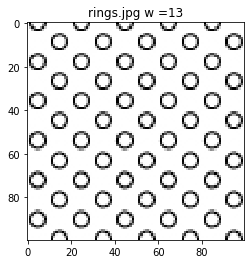

## Image texture.jpg | w = 5 ##
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


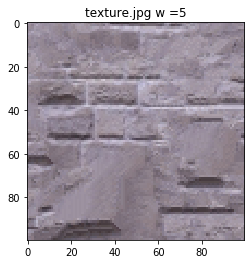

## Image texture.jpg | w = 7 ##
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


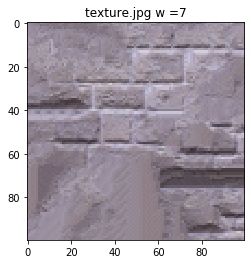

## Image texture.jpg | w = 13 ##
10 % complete
21 % complete
31 % complete
41 % complete
51 % complete
60 % complete
70 % complete
80 % complete
91 % complete


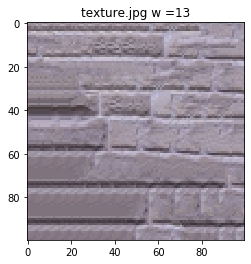

In [17]:
def main():
    
    source_files = [
        "rings.jpg",
        "texture.jpg"
    ]
    
    window_sizes = [
        5, 7, 13
    ]
    
    for filename in source_files:
        for w in window_sizes:
            print("## Image %s | w = %s ##" % (filename, str(w)))
            source = cv2.imread(filename)
            target = Synth_texture(source, w, [100, 100])

            plt.imshow(target[:,:,::-1])
            
            title = filename + ' w =' + str(w)
            plt.title(filename + ' w =' + str(w))
            outname = filename.split(".")[0] + "w=" + str(w) + ".png"
            plt.savefig(outname)
            plt.show()
            
main()

### Results

    Let the source image size be $N$, target image size be $S$ and window size be $w$. Then for each of the $S^2$ pixels in the output, we are considering $(N-W)^2$ candidate pixels. Each candidate is scored by computing the squared difference of two $w$ size matrixes, so the total runtime is $O(S^2 (N-W)^2 w^2) = O(S^2N^2w^2)$ since $N >> w$, i.e. quadratic in the window size.

    Therefore $w=7$ will be about twice as slow as $w=5$, and $w=13$ will be 6 to 7 times as slow as $w=5$.

    While decreasing computational performance, increasing the window size improves the quality of the resulting texture. This is because we are considering a bigger window, and therefore the algorithm increases the probability that this pixel value "makes sense" in that part of the image. We can see from the outputs below that for small windows, the algorithm does okay-ish for some parts of the image, but the results deteriorate at a certain point.

    We will not get the same picture if we start with the same image seed, as we are choosing a random pixel from the candidates returned by Find_matches(). If we chose this pixel deterministically, let's say by always picking the best match, we should get the same image every time. This holds for all window sizes.

![Image](ringsw=5.png)
![Image](ringsw=7.png)
![Image](ringsw=13.png)
![Image](texturew=5.png)
![Image](texturew=7.png)
![Image](texturew=13.png)